In [1]:
import numpy as np
import cv2
import scipy
import matplotlib.pyplot as plt
from Utils.Utils import *
import math

In [2]:
def createGaussianMask(image_size, sigma_x, sigma_y):
    cols, rows = image_size
    centre_x, centre_y = rows / 2, cols / 2
    x = np.linspace(0, rows, rows)
    y = np.linspace(0, cols, cols)
    X, Y = np.meshgrid(x,y)
    mask = np.exp(-(np.square((X - centre_x)/sigma_x) + np.square((Y - centre_y)/sigma_y)))
    return mask

In [3]:
def findContour(image):
    ret,thresh = cv2.threshold(np.uint8(image), 200 ,255,cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    chosen_contours = []

    previous_area = cv2.contourArea(contours[0])
    for j in range(len(contours)):
        if hierarchy[0, j, 3] == -1:#no parent
            if hierarchy[0, j, 2] !=-1: #child
                #print("no parent, child present")
                area = cv2.contourArea(contours[j])
                if True: #np.abs(area - previous_area) < 1000:
                    chosen_contours.append(contours[j])
                    previous_area = area

    return chosen_contours

In [4]:
def getTagMask(image):
    image_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    image_gray = cv2.GaussianBlur(image_gray, (21, 21), 0)

    chosen_contours = findContour(image_gray)
    out_mask = np.zeros_like(image_gray)
    corners = []
    for chosen_contour in chosen_contours:
        corner = cv2.approxPolyDP(chosen_contour, 0.009 * cv2.arcLength(chosen_contour, True), True)
        corners.append(corner.reshape(-1,2))
        cv2.drawContours(out_mask, [chosen_contour], -1, 1, cv2.FILLED)  

    out_mask_mul = np.dstack((out_mask, out_mask, out_mask))
    detected_april_tag = image_rgb * out_mask_mul
    return detected_april_tag


In [5]:
def getTagCorners(image):

    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_gray = cv2.medianBlur(image_gray, 3)

    (T, thresh) = cv2.threshold(image_gray, 180, 255, cv2.THRESH_BINARY)
    contours, hierarchy=cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    ctr=[]
    for j, cnt in zip(hierarchy[0], contours):
        cnt_len = cv2.arcLength(cnt,True)
        cnt = cv2.approxPolyDP(cnt, 0.02*cnt_len,True)
        # ctr.append(cnt)

        if cv2.isContourConvex(cnt) and len(cnt) == 4 and cv2.contourArea(cnt) > 500 :
            cnt=cnt.reshape(-1,2)
            #if j[0] == -1 and j[1] == -1 and j[3] != -1:
            if j[2] != -1 and j[3] != -1:
                ctr.append(cnt)
    return ctr


In [18]:
def extractInfoFromTag(tag):

    tag_size = tag.shape[0]
    grid_size = 8
    pixels_in_one_grid =  int(tag_size/8)

    info_with_padding = np.zeros((8,8))

    for i in range(0, grid_size, 1):
        for j in range(0, grid_size, 1):
            grid = tag[i*pixels_in_one_grid:(i+1)*pixels_in_one_grid, j*pixels_in_one_grid:(j+1)*pixels_in_one_grid]
            
            if np.sum(grid) > 100000*0.7 and np.median(grid) == 255:
                # print(np.sum(grid))
                info_with_padding[i,j] = 255
    # print(info_with_padding)
    info = info_with_padding[2:6, 2:6]
    return info

In [24]:
def rotatePoints(points):
    point_list = list(points.copy())
    top = point_list.pop(-1)
    point_list.insert(0, top)
    return np.array(point_list)


In [25]:
BasePath = '/home/sakshi/courses/ENPM673/sakshi_p1/'
video_file = BasePath + "Data/Tag0.mp4"
cap = cv2.VideoCapture(video_file)

testudoFileName = BasePath + "Data/testudo.jpg"
testudo_image = cv2.imread(testudoFileName)
if testudo_image is None:
    print("testudo image no found!")


testudo_x = testudo_image.shape[0]
testudo_y = testudo_image.shape[1]

testudo_corners = np.array([[0,0], [0, testudo_y], [testudo_x, testudo_y], [testudo_x, 0]])
testudo_corners = sortCorners(testudo_corners)

count = 0
number_of_tags = 1
chosen_frame = 0
chosen_corners = 0

tag_size = 160
desired_tag_corner = sortCorners(np.array([ [0, tag_size], [tag_size, tag_size], [tag_size, 0], [0, 0]]))



while(True):
    
    ret, frame = cap.read()
    if not ret:
        print("Stream ended..")
        break
    
    image_rgb = frame
    rows,cols,ch = image_rgb.shape
    
    detected_april_tag = np.uint8(getTagMask(image_rgb))

    if (count==0):
        old_corners = getTagCorners(detected_april_tag)
        number_of_tags = len(old_corners)
        old_rotation = 0

    corners = getTagCorners(detected_april_tag)

    if(len(corners) < 1):
        corners = old_corners
    else:
        old_corners = corners

    # cv2.drawContours(detected_april_tag, corners,0,(0,255,0),5)
    if len(corners) > 3:
        print(len(corners))
    for corner in corners:
        cv2.drawContours(detected_april_tag, [corner], 0, (0,255,0), 5)

    for corner in corners:
        set1 = testudo_corners
        set2 = sortCorners(corner)

        # H12 = computeHomography(set1, set2)
        # dst = applyHomography2ImageUsingForwardWarping(testudo_image, H12, (cols, rows))

        Htd = computeHomography(np.float32(set2), np.float32(desired_tag_corner))
        tag = applyHomography2ImageUsingInverseWarping(image_rgb, Htd, (tag_size, tag_size))
        tag = cv2.cvtColor(np.uint8(tag), cv2.COLOR_BGR2GRAY)
        ret,tag = cv2.threshold(np.uint8(tag), 230 ,255,cv2.THRESH_BINARY)

        tag_info = extractInfoFromTag(tag)

        corners = np.array([tag_info[0,0], tag_info[0,3], tag_info[3,0], tag_info[3,3]])

        rotation = 0 
        if not (np.all(corners == 255) or np.all(corners == 0)):
            while not tag_info[3,3]:
                tag_info = np.rot90(tag_info, 1)
                rotation = rotation + 90
            
            old_rotation = rotation
        else:
            print("Tag not detected properly!")
            rotation = old_rotation

        print("rotation = ", rotation)
        num_rotations = int(rotation/90)
        for n in range(num_rotations):
            set2 = rotatePoints(set2)

        H12 = computeHomography(set1, set2)
        dst = applyHomography2ImageUsingForwardWarping(testudo_image, H12, (cols, rows))

        plt.imshow(tag, cmap= 'gray')

        cv2.fillConvexPoly(image_rgb, set2.astype(int), 0, 16)
        image_show = image_rgb + dst

    if count == 10:
        chosen_frame = image_rgb
        chosen_corners = corners

    count = count + 1
    cv2.imshow('frame', np.uint8(dst))
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

rotation =  180
rotation =  180
rotation =  180
rotation =  180
rotation =  180
rotation =  180
rotation =  180
rotation =  180
rotation =  180
rotation =  180
rotation =  180
rotation =  180
rotation =  180
rotation =  180
rotation =  180
rotation =  180
rotation =  180
rotation =  180
rotation =  180
rotation =  180
rotation =  180
rotation =  180
rotation =  180
rotation =  180
rotation =  180
rotation =  180
rotation =  180
rotation =  180
rotation =  180
rotation =  180
rotation =  180
rotation =  180
rotation =  180
rotation =  180
rotation =  180
rotation =  180
rotation =  180
rotation =  180
rotation =  180
rotation =  180
rotation =  180
rotation =  180
rotation =  180


KeyboardInterrupt: 

In [26]:
cv2.destroyAllWindows()

In [145]:
tag_corner = np.array([ [0, tag_size], [tag_size, tag_size], [tag_size, 0], [0, 0]])
print(tag_corner)
sortCorners(tag_corner)

[[  0 160]
 [160 160]
 [160   0]
 [  0   0]]


array([[  0,   0],
       [  0, 160],
       [160, 160],
       [160,   0]])

In [143]:
tag_corner

array([[  0, 160],
       [160, 160],
       [160,   0],
       [  0,   0]])

In [144]:
def sortCorners(points):

    x_sorted = points[np.argsort(points[:,0])]

    points_left = x_sorted[0:2, :]
    points_right = x_sorted[2:4, :]

    left_sorted_y = points_left[np.argsort(points_left[:,1])]
    tl, bl = left_sorted_y

    right_sorted_y = points_right[np.argsort(points_right[:,1])]
    tr, br = right_sorted_y
    points_sorted = np.array([tl, bl, br, tr])
    return points_sorted

In [138]:
points = tag_corner
x_sorted = points[np.argsort(points[:,0])]

points_left = x_sorted[0:2, :]
points_right = x_sorted[2:4, :]

left_sorted_y = points_left[np.argsort(points_left[:,1])]
tl, bl = left_sorted_y

right_sorted_y = points_right[np.argsort(points_right[:,1])]
tr, br = right_sorted_y
points_sorted = np.array([tl, bl, br, tr])



In [139]:
points_sorted

array([[1052,  564],
       [1093,  627],
       [1163,  597],
       [1121,  535]], dtype=int32)

In [140]:
type(tag_corner)

numpy.ndarray

In [116]:
a = np.angle(v) * 180 / np.pi
print(a)
s = tag_corner[a.argsort()]
s

[25.51292431 27.17268121 29.84075957 28.1967236 ]


array([[1121,  535],
       [1163,  597],
       [1052,  564],
       [1093,  627]], dtype=int32)

In [103]:
centroid = tag_corner[1]
print(centroid)

[160 160]


(1920, 1920, 3)


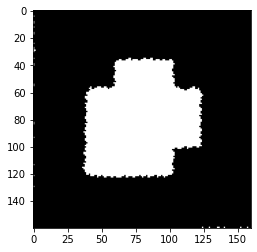

In [20]:
tag = applyHomography2ImageUsingInverseWarping(chosen_frame, Htd, (tag_size, tag_size))
tag = cv2.cvtColor(np.uint8(tag), cv2.COLOR_BGR2GRAY)
ret,tag = cv2.threshold(np.uint8(tag), 230 ,255,cv2.THRESH_BINARY)
plt.imshow(tag, cmap= 'gray')